In [20]:
# Gerekli kütüphaneleri import edelim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from PIL import Image
from tqdm import tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import os

directory = '/content/drive/MyDrive/ColabNotebooks/fishClassifictions/archive/Fish_Dataset/Fish_Dataset'
print(os.path.exists(directory))  # True dönerse yol doğru, False dönerse yol hatalı


True


belirtilen dizindeki sadece klasör isimlerini listelemek için kullanılır.

In [5]:
classes = [i for i in os.listdir(directory) if '.' not in i]
classes

['Sea Bass',
 'Gilt-Head Bream',
 'Red Sea Bream',
 'Red Mullet',
 'Shrimp',
 'Black Sea Sprat',
 'Hourse Mackerel',
 'Striped Red Mullet',
 'Trout']

belirtilen dizindeki klasörlerden .png uzantılı dosyaların yollarını ve bu dosyaların ait olduğu sınıf etiketlerini label ve path listelerine ekleyip, ardından bu bilgileri bir pandas DataFrame'e dönüştürür.

In [6]:
label = []
path = []

for dir_name, _, filenames in os.walk(directory):
    for filename in filenames:
        if dir_name.split()[-1] != 'GT':
            if os.path.splitext(filename)[-1] == '.png':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label


In [7]:
data

,path,label
0,/content/drive/MyDrive/ColabNotebooks/fishClas...,Sea Bass
1,/content/drive/MyDrive/ColabNotebooks/fishClas...,Sea Bass
2,/content/drive/MyDrive/ColabNotebooks/fishClas...,Sea Bass
3,/content/drive/MyDrive/ColabNotebooks/fishClas...,Sea Bass
4,/content/drive/MyDrive/ColabNotebooks/fishClas...,Sea Bass
...,...,...
9013,/content/drive/MyDrive/ColabNotebooks/fishClas...,Trout
9014,/content/drive/MyDrive/ColabNotebooks/fishClas...,Trout
9015,/content/drive/MyDrive/ColabNotebooks/fishClas...,Trout
9016,/content/drive/MyDrive/ColabNotebooks/fishClas...,Trout


In [8]:
data.path[0]

'/content/drive/MyDrive/ColabNotebooks/fishClassifictions/archive/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00010.png'

data DataFrame'inde yer alan label sütunundaki her bir sınıfın kaç kez tekrarlandığını sayarak bu sınıfların frekanslarını gösterir.

In [9]:
data.label.value_counts()

,count
label,
Striped Red Mullet,1010
Hourse Mackerel,1008
Sea Bass,1000
Gilt-Head Bream,1000
Red Sea Bream,1000
Shrimp,1000
Red Mullet,1000
Black Sea Sprat,1000
Trout,1000


In [10]:
data.isnull().sum()

,0
path,0
label,0


her bir balık sınıfından (etiketlerden) bir örnek görüntüyü yan yana gösteren bir grafik oluşturur. Her sınıf için ilk resim seçilir ve 3x3'lik bir alt grafik (subplot) düzeninde görselleştirilir, böylece farklı balık türlerine ait örnekler aynı grafik üzerinde görüntülenir.

In [11]:
cn = 0
plt.figure(figsize=(20, 20))
for unique_label in data['label'].unique():
    plt.subplot(3, 3, cn + 1)
    plt.imshow(plt.imread(data[data['label'] == unique_label].iloc[0, 0]))
    plt.title(unique_label)
    plt.axis('off')
    cn += 1


Output hidden; open in https://colab.research.google.com to view.

 her bir görseli yeniden boyutlandırarak, düzleştirip normalize ederek bir numpy dizisi haline getirir ve görsellerle etiketleri ayrı listelere ekler. Sonrasında bu listeleri, X ve y değişkenlerine numpy array olarak dönüştürür ve şekillerini ekrana yazdırır.

In [12]:
# Görselleri ve etiketleri depolamak için listeler oluşturuyoruz
image_data = []
labels = []

# Görselleri 64x64 boyutuna getirip, düzleştirip ve normalize ediyoruz
for idx, row in tqdm(data.iterrows(), total=data.shape[0]):
    img_path = row['path']
    label = row['label']
    # Görseli açıyoruz
    img = Image.open(img_path).convert('RGB')  # Siyah-beyaz görselleri de kapsamak için RGB'ye çeviriyoruz
    # Görseli 64x64 boyutuna yeniden boyutlandırıyoruz
    img = img.resize((64, 64))
    # Görseli numpy array'e dönüştürüyoruz
    img_array = np.array(img)
    # Görseli düzleştiriyoruz
    img_flat = img_array.flatten()
    # Görseli normalize ediyoruz
    img_norm = img_flat / 255.0
    # Listelere ekliyoruz
    image_data.append(img_norm)
    labels.append(label)

# Listeleri numpy array'e dönüştürüyoruz
X = np.array(image_data)
y = np.array(labels)

print("X verisinin şekli:", X.shape)
print("y verisinin şekli:", y.shape)


100%|██████████| 9018/9018 [38:45<00:00,  3.88it/s]


X verisinin şekli: (9018, 12288)
y verisinin şekli: (9018,)


etiketler önce LabelEncoder ile sayısal değerlere dönüştürülüyor. Ardından, bu sayısal etiketler to_categorical fonksiyonu kullanılarak one-hot encoding işlemine tabi tutuluyor. Kodlanan etiketlerin ve one-hot encoding sonrası etiketlerin şekilleri ekrana yazdırılıyor.

In [13]:
# LabelEncoder ile etiketleri sayısal değerlere dönüştürüyoruz
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Kodlanmış etiketler:", np.unique(y_encoded))

# One-hot encoding işlemi
y_onehot = to_categorical(y_encoded)

print("y_onehot verisinin şekli:", y_onehot.shape)


Kodlanmış etiketler: [0 1 2 3 4 5 6 7 8]
y_onehot verisinin şekli: (9018, 9)


In [14]:
# Veri setini eğitim ve test olarak ayırıyoruz
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded)

print("X_train şekli:", X_train.shape)
print("X_test şekli:", X_test.shape)
print("y_train şekli:", y_train.shape)
print("y_test şekli:", y_test.shape)


X_train şekli: (7214, 12288)
X_test şekli: (1804, 12288)
y_train şekli: (7214, 9)
y_test şekli: (1804, 9)


Bu model, dört gizli katman ve bir çıktı katmanından oluşan bir yapay sinir ağıdır. İlk dört katmanda sırasıyla 512, 256, 128 ve 64 nöron bulunur ve her biri için aktivasyon fonksiyonu olarak relu kullanılmıştır. Her katmandan sonra BatchNormalization ile veriler normalize edilmekte ve aşırı öğrenmeyi önlemek amacıyla Dropout(0.3) ile %30 oranında nöronlar rastgele devre dışı bırakılmaktadır. Son katmanda, 9 sınıf için çıktı üreten softmax aktivasyon fonksiyonlu bir katman bulunmaktadır.

In [29]:
# Modeli tanımlıyoruz
model = Sequential()

# İlk gizli katman
model.add(Dense(512, activation='relu', input_shape=(12288,)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# İkinci gizli katman
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Üçüncü gizli katman
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dördüncü gizli katman
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Çıktı katmanı
model.add(Dense(9, activation='softmax'))  # 9 sınıfımız var


In [30]:
# Modeli derliyoruz
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [31]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 512)                 │       6,291,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,468,873 (24.68 MB)

 Trainable params: 6,466,953 (24.67 MB)

 Non-trainable params: 1,920 (7.50 KB)

model eğitimi sırasında erken durdurma (EarlyStopping) işlemini tanımlar. val_loss (doğrulama kaybı) izlenir ve doğrulama kaybı 30 dönem (epoch) boyunca iyileşmediği takdirde eğitim durdurulur. restore_best_weights=True parametresi, en iyi doğrulama kaybı değerine sahip ağırlıkların geri yüklenmesini sağlar ve verbose=1 parametresi ise eğitim sırasında bilgilendirici çıktılar verir.

In [32]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=30,
                           restore_best_weights=True,
                           verbose=1)

In [33]:
# Modeli eğitiyoruz
history = model.fit(X_train, y_train, epochs=250, batch_size=32,validation_data=(X_test, y_test), callbacks=[early_stop])


Epoch 1/250
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.2464 - loss: 2.3039 - val_accuracy: 0.5560 - val_loss: 1.3000
Epoch 2/250
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4954 - loss: 1.4469 - val_accuracy: 0.6829 - val_loss: 0.9528
Epoch 3/250
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6231 - loss: 1.0952 - val_accuracy: 0.6369 - val_loss: 1.0340
Epoch 4/250
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6888 - loss: 0.9063 - val_accuracy: 0.6325 - val_loss: 1.0197
Epoch 5/250
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7329 - loss: 0.7799 - val_accuracy: 0.7982 - val_loss: 0.5681
Epoch 6/250
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7662 - loss: 0.6916 - val_accuracy: 0.6674 - val_loss: 1.1155
Epoch 7/250
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7857 - loss: 0.6363 - val_accuracy: 0.7023 - val_loss: 0.9415
Epoch 8/250
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7969 - loss: 0.6158 - val_ac

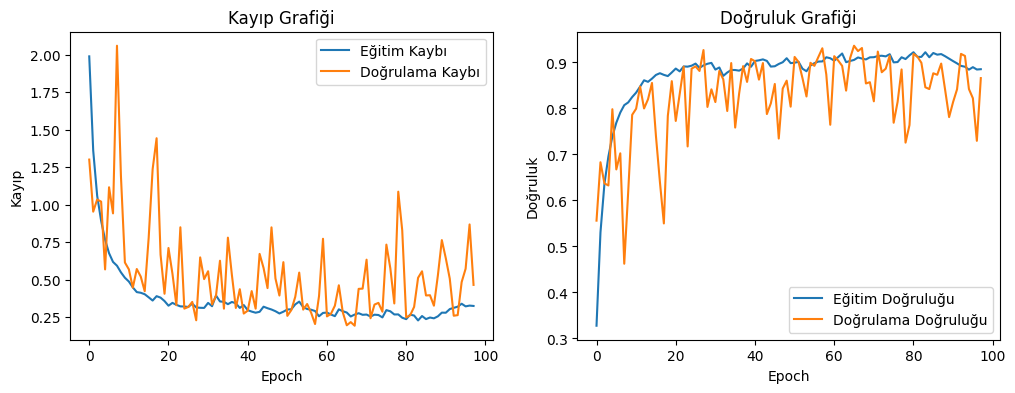

In [34]:
# Eğitim ve doğrulama kayıpları
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Eğitim ve doğrulama doğrulukları
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.show()


In [35]:
# Test verisi üzerinde modelin performansı
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Kayıp:", test_loss)
print("Test Doğruluk:", test_accuracy)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9242 - loss: 0.2118
Test Kayıp: 0.19278168678283691
Test Doğruluk: 0.9312638640403748


In [36]:
# Test verisi üzerinde tahminler
y_pred_proba = model.predict(X_test)
# Tahmin edilen sınıf indeksleri
y_pred_classes = np.argmax(y_pred_proba, axis=1)
# Gerçek sınıf indeksleri
y_true_classes = np.argmax(y_test, axis=1)

# Sınıf indekslerini etiket isimlerine dönüştürme
y_pred_labels = le.inverse_transform(y_pred_classes)
y_true_labels = le.inverse_transform(y_true_classes)

# Sonuçları bir DataFrame'de toplama
results_df = pd.DataFrame({'Gerçek Balık İsmi': y_true_labels, 'Tahmin Edilen Balık İsmi': y_pred_labels})

# İlk 20 satırı görüntüleyelim
results_df.head(20)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


,Gerçek Balık İsmi,Tahmin Edilen Balık İsmi
0,Hourse Mackerel,Hourse Mackerel
1,Red Mullet,Red Mullet
2,Shrimp,Shrimp
3,Black Sea Sprat,Black Sea Sprat
4,Hourse Mackerel,Hourse Mackerel
5,Striped Red Mullet,Black Sea Sprat
6,Red Mullet,Red Mullet
7,Black Sea Sprat,Black Sea Sprat
8,Red Sea Bream,Red Sea Bream
9,Hourse Mackerel,Hourse Mackerel


In [37]:
from sklearn.metrics import classification_report, confusion_matrix

# Sınıflandırma raporu
print("Sınıflandırma Raporu:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))


Sınıflandırma Raporu:
                    precision    recall  f1-score   support

   Black Sea Sprat       0.90      0.99      0.94       200
   Gilt-Head Bream       0.93      0.83      0.88       200
   Hourse Mackerel       0.94      0.93      0.94       202
        Red Mullet       0.99      0.99      0.99       200
     Red Sea Bream       0.96      0.93      0.94       200
          Sea Bass       0.90      0.92      0.91       200
            Shrimp       0.93      0.99      0.96       200
Striped Red Mullet       0.93      0.91      0.92       202
             Trout       0.91      0.89      0.90       200

          accuracy                           0.93      1804
         macro avg       0.93      0.93      0.93      1804
      weighted avg       0.93      0.93      0.93      1804



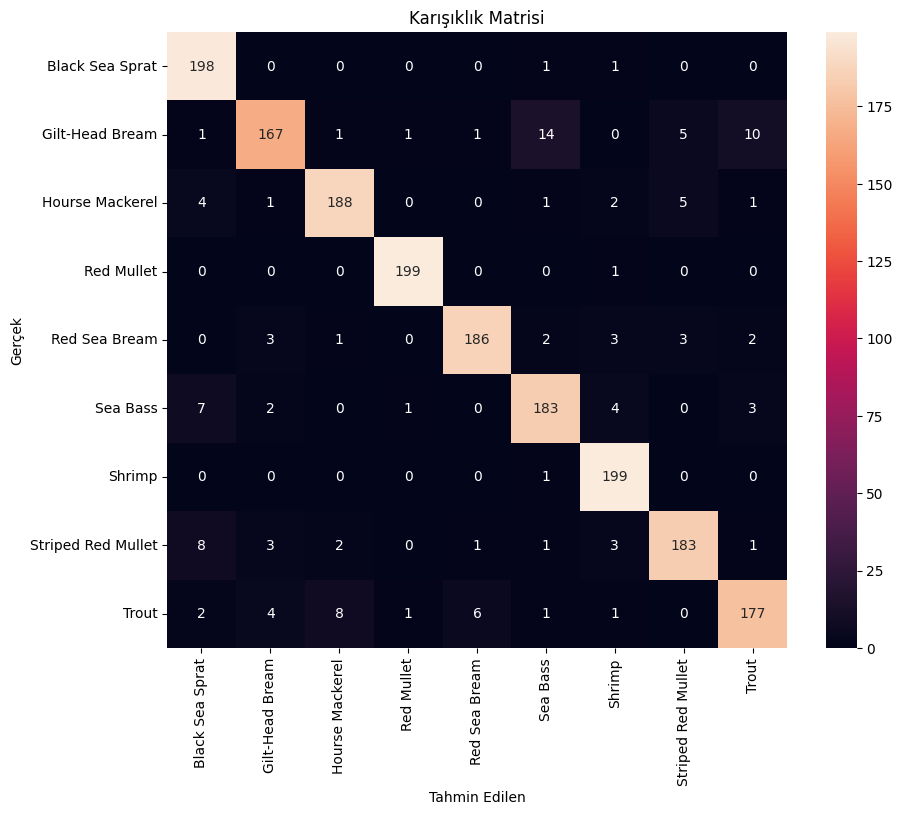

In [38]:
# Karışıklık matrisi
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Karışıklık matrisini görselleştirme
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Karışıklık Matrisi')
plt.show()


test setinden rastgele 10 örnek seçip görselleştiren bir işlemi gerçekleştirir. İlk olarak, test setindeki görüntülerden rastgele 10 indeks belirlenir. Daha sonra, her bir görüntü için aşağıdaki işlemler yapılır: Görsel verisi alınır, düzleştirilmiş görüntü yeniden şekillendirilir ve piksel değerleri 0-255 aralığına geri çevrilerek uint8 veri tipine dönüştürülür. Ardından, her görüntü için gerçek etiket ve modelin tahmin ettiği etiket hesaplanır. Son olarak, her bir görüntü ve ilgili etiket bilgileri, bir ızgara düzeninde görselleştirilerek gösterilir. Bu işlem, modelin performansını görsel olarak değerlendirmek için kullanılır.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


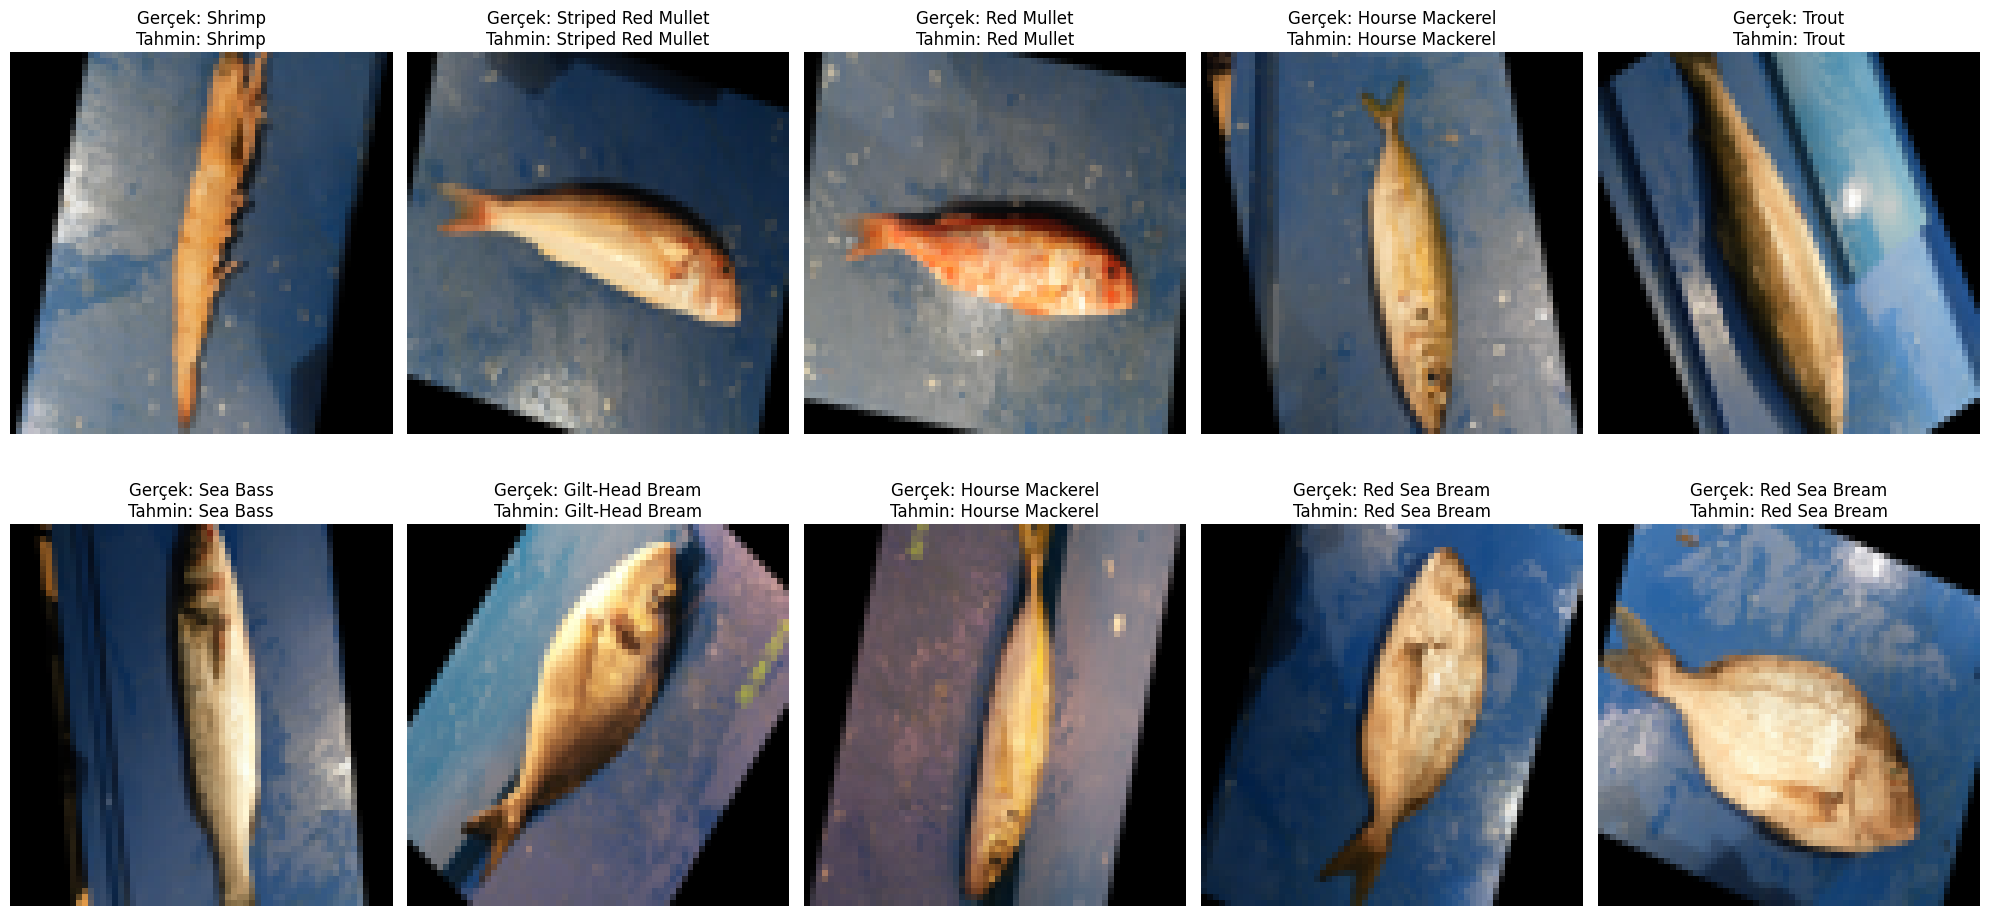

In [42]:
# Rastgele 10 test örneğini seçme ve görselleştirme

import random

# Rastgele 10 indeks seçiyoruz
random_indices = random.sample(range(len(X_test)), 10)

# Figure oluşturuyoruz
plt.figure(figsize=(20, 10))

for i, idx in enumerate(random_indices):
    # Görsel verisini alıyoruz
    img_flat = X_test[idx]
    # Görseli yeniden şekillendiriyoruz
    img_array = img_flat.reshape(64, 64, 3)
    # Piksel değerlerini geri çeviriyoruz (denormalize)
    img_array = img_array * 255.0
    # Veri tipini uint8 yapıyoruz
    img_array = img_array.astype('uint8')

    # Gerçek etiketi alıyoruz
    actual_label_index = np.argmax(y_test[idx])
    actual_label = le.inverse_transform([actual_label_index])[0]

    # Tahmin edilen etiketi alıyoruz
    pred_proba = model.predict(np.expand_dims(X_test[idx], axis=0))
    pred_label_index = np.argmax(pred_proba)
    predicted_label = le.inverse_transform([pred_label_index])[0]

    # Görseli plot ediyoruz
    plt.subplot(2, 5, i+1)
    plt.imshow(img_array)
    plt.title(f"Gerçek: {actual_label}\nTahmin: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
